In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Importing the data from Johns Hopkins repo

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

## Data Preprocessing

In [3]:
na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

In [4]:
## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

In [5]:
confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

In [6]:
full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})
# Check null values
full_df.isnull().sum()

Country               0
Province/State    21700
Lat                   0
Long                  0
Date                  0
Confirmed             0
Recoveries            0
Deaths                0
dtype: int64

In [7]:
world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

world_df = add_rates(world_df)

## World data

In [43]:
world_df

,Date,Confirmed,Recoveries,Deaths,Confirmed Change,Mortality Rate,Recovery Rate,Growth Rate,Growth Rate Change,Growth Rate Accel
0,2020-01-22,540,28,17,89.0,0.031481,0.051852,0.164815,0.270797,1.643040
1,2020-01-23,629,30,18,274.0,0.028617,0.047695,0.435612,0.058297,0.133828
2,2020-01-24,903,35,25,446.0,0.027685,0.038760,0.493909,-0.038757,-0.078470
3,2020-01-25,1349,38,41,614.0,0.030393,0.028169,0.455152,-0.080725,-0.177358
4,2020-01-26,1963,51,53,735.0,0.026999,0.025981,0.374427,0.577019,1.541071
...,...,...,...,...,...,...,...,...,...,...
119,2020-05-20,4896478,1845620,321393,103777.0,0.065638,0.376928,0.021194,0.000148,0.006997
120,2020-05-21,5000255,1895646,326067,106718.0,0.065210,0.379110,0.021343,-0.002160,-0.101193
121,2020-05-22,5106973,2001926,331198,97966.0,0.064852,0.391999,0.019183,-0.000835,-0.043540
122,2020-05-23,5204939,2056605,335019,95498.0,0.064366,0.395126,0.018348,NaN,NaN


In [59]:
df=pd.DataFrame(world_df['Confirmed'])

In [60]:
df

,Confirmed
0,540
1,629
2,903
3,1349
4,1963
...,...
119,4896478
120,5000255
121,5106973
122,5204939


## Feature Scaling

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [62]:
scaler.scale_

array([1.88682912e-07])

## Data prepration for LSTM

In [63]:
train_size=100
test_size=len(df)-train_size

In [64]:
train=df[0:train_size,:]

In [65]:
test=df[train_size:len(df),:]

In [66]:
train.shape

(100, 1)

In [67]:
test.shape

(24, 1)

### Creating the batches of data to feed the network 

In [68]:
def data_gen(df,n):
    list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]
    
    X,y=[],[]
    a=0
    for i in list_df:
        if a%2==0:
            X.append(i)
        else:
            y.append(i)
        a+=1
    return np.array(X),np.array(y)

In [69]:
X_train,y_train=data_gen(train,2)

In [70]:
X_test,y_test=data_gen(test,2)

In [71]:
def re_shape(data):
    correct_data=[]
    for i in data:
        a=i.tolist()
        correct_data.append(a)
    return correct_data

In [57]:
X_train=np.array(X_train[0:-1])

In [72]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(25, 2, 1) (25, 2, 1) (6, 2, 1) (6, 2, 1)


### Many to many LSTM model
it will take previous 5 days data and able to predict no. of cases in next 5 days
Input = 5 days
Output = 5 days

In [73]:
model = Sequential()
model.add(LSTM(60, dropout=0.1,recurrent_dropout=0.2, input_shape=(2,1)))
model.add(RepeatVector(2))
model.add(LSTM(36, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='RMSprop', loss='mae')

In [93]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(2,1)))
model.add(RepeatVector(2))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='RMSprop', loss='mean_absolute_error')

In [94]:
history = model.fit(X_train, y_train, epochs=1000,batch_size=1)

Epoch 1/1000
25/25 [==============================] - 1s 39ms/step - loss: 0.1279
Epoch 2/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.1066
Epoch 3/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0634
Epoch 4/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0462
Epoch 5/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0420
Epoch 6/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0418
Epoch 7/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0388
Epoch 8/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0375
Epoch 9/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0344
Epoch 10/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0322
Epoch 11/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0284
Epoch 12/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0231
Epoch 13/1000

25/25 [==============================] - 0s 12ms/step - loss: 0.0119
Epoch 100/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0106
Epoch 101/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 102/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 103/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 104/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 105/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0101
Epoch 106/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 107/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0082
Epoch 108/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 109/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0113
Epoch 110/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0091
Epoch 1

25/25 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 197/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0083
Epoch 198/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 199/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 200/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0078
Epoch 201/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0077
Epoch 202/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0110
Epoch 203/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0086
Epoch 204/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0074
Epoch 205/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 206/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 207/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 2

25/25 [==============================] - 0s 11ms/step - loss: 0.0075
Epoch 294/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0082
Epoch 295/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 296/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 297/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 298/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0074
Epoch 299/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0075
Epoch 300/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 301/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0093
Epoch 302/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0077
Epoch 303/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0059
Epoch 304/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0079
Epoch 3

25/25 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 391/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 392/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 393/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 394/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 395/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 396/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 397/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 398/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 399/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0071
Epoch 400/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0074
Epoch 401/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 4

25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 488/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 489/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 490/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 491/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 492/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 493/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 494/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 495/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 496/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 497/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 498/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 4

25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 585/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 586/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 587/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 588/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 589/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 590/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 591/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 592/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 593/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 594/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 595/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0072
Epoch 5

25/25 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 682/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0059
Epoch 683/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 684/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 685/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 686/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 687/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 688/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 689/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0063
Epoch 690/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 691/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0067
Epoch 692/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 6

25/25 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 779/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 780/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0059
Epoch 781/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 782/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 783/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 784/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 785/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 786/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 787/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 788/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 789/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 7

25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 876/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 877/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 878/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0045
Epoch 879/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 880/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 881/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 882/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 883/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 884/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 885/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 886/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 8

25/25 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 973/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0056
Epoch 974/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 975/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 976/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 977/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 978/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 979/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 980/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 981/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 982/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0058
Epoch 983/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0050
Epoch 9

In [85]:
# list all data in history
print(history.history.keys())

dict_keys(['loss'])


Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

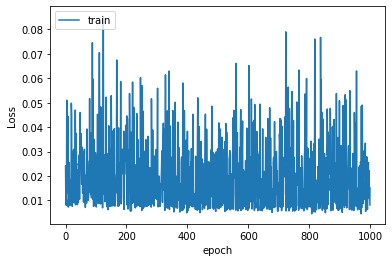

In [86]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
y_pred=model.predict(X_test)

In [88]:
for i in y_pred:
    y_pred=scaler.inverse_transform(i)

In [89]:
for i in y_test:
    y_test=scaler.inverse_transform(i)

ValueError: Expected 2D array, got 1D array instead:
array=[5204939.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

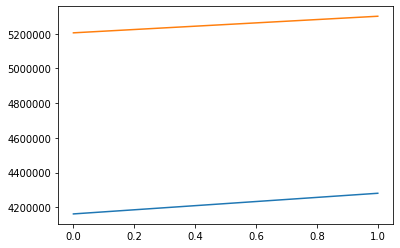

In [90]:
plt.plot(y_pred)
plt.plot(y_test)

In [91]:
y_pred

array([[4162416.5],
       [4281294.5]], dtype=float32)

In [92]:
y_test

array([[5204939.],
       [5300437.]])